# Visualizaciones estáticas

- Sebastian Aristondo 20880  
- Diego Franco 20240  
- Manuel Archila 161250  
- Juan Diego Avila 20090  
- Daniel Gonzalez Carrillo 20293  

In [1]:
import pandas as pd
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import ndimage
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import cv2
from PIL import Image
from zipfile import ZipFile
from torchvision import transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import os
from sklearn.metrics import precision_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import seaborn as sns

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

In [4]:
if torch.cuda.is_available():
    print('GPU está disponible')
else:
    print('No se encontró GPU, usando CPU')

GPU está disponible


In [5]:
def get_metrics(matrix):
    precision = []
    recall = []
    f1 = []
    tp = matrix[0][0]
    fp = matrix[0][1]
    fn = matrix[1][0]
    tn = matrix[1][1]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return accuracy, recall, f1

## 3D CNN

In [43]:
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes):
        super(Simple3DCNN, self).__init__()
        
        # Capa 3D Conv1
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        # Capa 3D Conv2
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        #Forzar dimensionalidad
        self.fce = nn.Linear(4800, 2400) # (64 * 75, 64*75/2)
        self.relue1 = nn.ReLU()  
        self.fce2 = nn.Linear(2400, 240)
        self.relue2 = nn.ReLU()
        self.fce3 = nn.Linear(240, 128)
        self.relue3 = nn.ReLU()
        self.fce4 = nn.Linear(128, 1)    
          
        # Capa completamente conectada
        self.fc1 = nn.Linear(64 * 4 * 4 * 4, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 7)
        
        self.softmax = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # forzar dimensionalidad
        x = x.view(-1, 64 * 75)
        x = self.fce(x)
        x = self.relue1(x)
        x = self.fce2(x)
        x = self.relue2(x)
        x = self.fce3(x)
        x = self.relue3(x)
        x = self.fce4(x)
        
        
        x = x.view(-1, 64 * 4 * 4 * 4)        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        x = self.softmax(x)
        
        return x

In [44]:
#Cargar datos 

class ImageDataGenerator3D:
    def __init__(self, volumes_ruta, csv, max_UID):
        self.volumes_ruta = volumes_ruta
        self.max_UID = max_UID
        self.current_UID = 0
        self.names = []
        self.df = csv
        self.read_volumes_path()
        
    def read_volumes_path(self):
        ruta_carpeta = self.volumes_ruta
        if os.path.exists(ruta_carpeta) and os.path.isdir(ruta_carpeta):
            objetos = os.listdir(ruta_carpeta)
            for objeto in objetos:
                objeto_ruta = os.path.join(ruta_carpeta, objeto)
                self.names.append(objeto_ruta)

    def reset_idx(self):
        self.current_UID = 0  
        
    def get_next_ruta(self):
        next_name = 'volumes/' + self.df.iloc[self.current_UID]['StudyInstanceUID'] + '.npy'
        return next_name
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_UID >= self.max_UID:
            # print("No hay mas datos")
            self.current_UID = 0
            raise StopIteration()
        else:
            # Cargar el volumen
            name = self.get_next_ruta()
            volume = np.load(name)
            #volume.resize((256, 256, 256))
            #label = [float(value) for value in self.df.iloc[self.current_UID][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].tolist()]
            label = self.df.iloc[self.current_UID][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].tolist()
            # Incrementar el UID
            self.current_UID += 1
            # Devolver el volumen
            return volume, label
        
    def __len__(self):
        # Devuelve la longitud total del generador
        return self.max_UID

In [45]:
num_classes = 7

In [46]:
model3D = Simple3DCNN(num_classes)
model3D.load_state_dict(torch.load('modelo_entrenado3D.pth'))

<All keys matched successfully>

In [47]:
model3D.to('cuda')

Simple3DCNN(
  (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu1): ReLU()
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu2): ReLU()
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fce): Linear(in_features=4800, out_features=2400, bias=True)
  (relue1): ReLU()
  (fce2): Linear(in_features=2400, out_features=240, bias=True)
  (relue2): ReLU()
  (fce3): Linear(in_features=240, out_features=128, bias=True)
  (relue3): ReLU()
  (fce4): Linear(in_features=128, out_features=1, bias=True)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)

In [48]:
data = pd.read_csv('train_filtrado_volumes.csv')
data = data.iloc[0:600]

In [49]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [50]:
data_gen = ImageDataGenerator3D('volumes', train_data, len(train_data))
test_data_gen = ImageDataGenerator3D('volumes', test_data, len(test_data))

In [51]:
accumulated_cm = np.zeros((7,2,2), dtype=int)

def calculate_matrix(predic_labels, labels):
    for i in range(len(labels)):
        if predic_labels[i] == 1 and labels[i] == 1:
            accumulated_cm[i][0][0] += 1
        elif predic_labels[i] == 1 and labels[i] == 0:
            accumulated_cm[i][0][1] += 1
        elif predic_labels[i] == 0 and labels[i] == 1:
            accumulated_cm[i][1][0] += 1
        elif predic_labels[i] == 0 and labels[i] == 0:
            accumulated_cm[i][1][1] += 1

In [52]:
model3D.eval()
accuracy_iter = 0
test_accuracy = []
accuracy_total = 0
confusion_matrices = []
with torch.no_grad():
    for i, (volume, label) in tqdm(enumerate(test_data_gen), total=len(test_data_gen)):
        image_tensor = torch.from_numpy(volume).unsqueeze(0).float().to('cuda')
        label_tensor = torch.tensor(label).unsqueeze(0).float().to('cuda')

        predictions = model3D(image_tensor)
        
        threshold = 0.5
        predicted_labels = (predictions > threshold).float()  # 1 si es mayor al umbral, 0 de lo contrario
        predicted_labels_np = predicted_labels.cpu().numpy()[0]
        labels_np = label_tensor.cpu().numpy()[0]
        # confusion_matrices.append(multilabel_confusion_matrix(label, predicted_labels_np))

        accuracy_per_class = (predicted_labels_np == label).mean(axis=0)
        calculate_matrix(predicted_labels_np, labels_np)
        # Calcular la precisión global (promedio de la precisión por clase)
        number_of_1 = np.count_nonzero(label)
        intersection = np.logical_and(predicted_labels_np, label)
        intersection_1 = np.count_nonzero(intersection)
        accuracy_iter = 0
        if  number_of_1 == 0:
            if intersection_1 > number_of_1:
                accuracy_iter = 0
            elif intersection_1 == 0:
                accuracy_iter = 1
        else:
            accuracy_iter = intersection_1 / number_of_1
            
        accuracy_total += accuracy_iter
        test_accuracy.append(accuracy_iter)

100%|██████████| 120/120 [02:19<00:00,  1.16s/it]


C:\Users\Daniel\AppData\Local\Temp\ipykernel_28148\2099467119.py:9: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_28148\2099467119.py:9: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_28148\2099467119.py:9: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_28148\2099467119.py:9: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_28148\2099467119.py:9: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_28148\2099467119.py:9: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Accuracy: 0.9083333333333333
Recall: 0.0
F1: nan
Accuracy: 0.8083333333333333
Recall: 0.0
F1: nan
Accuracy: 0.9583333333333334
Recall: 0.0
F1: nan
Accuracy: 0.9416666666666667
Recall: 0.0
F1: nan
Accuracy: 0.9333333333333333
Recall: 0.0
F1: nan
Accuracy: 0.8833333333333333
Recall: 0.0
F1: nan
Accuracy: 0.175
Recall: 1.0
F1: 0.28776978417266186


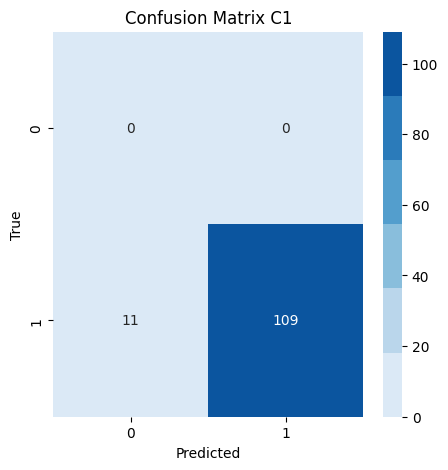

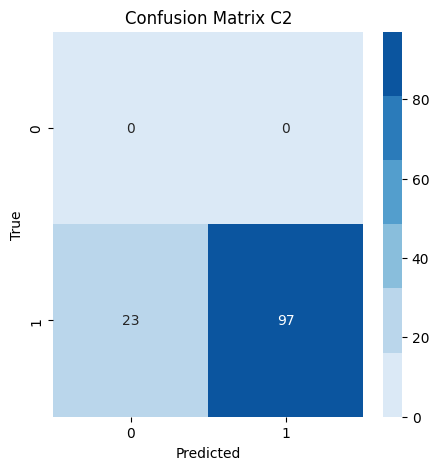

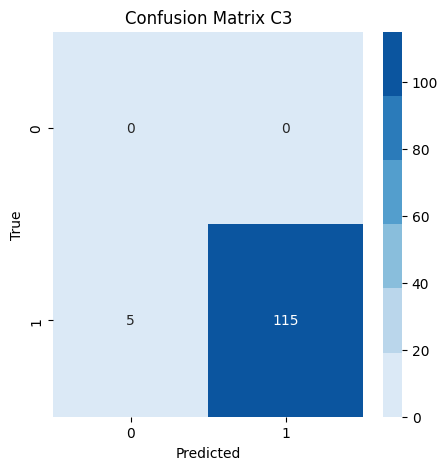

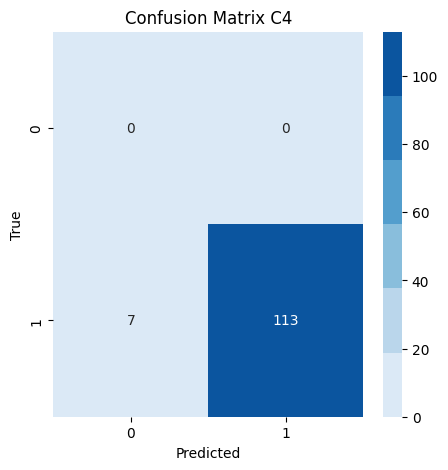

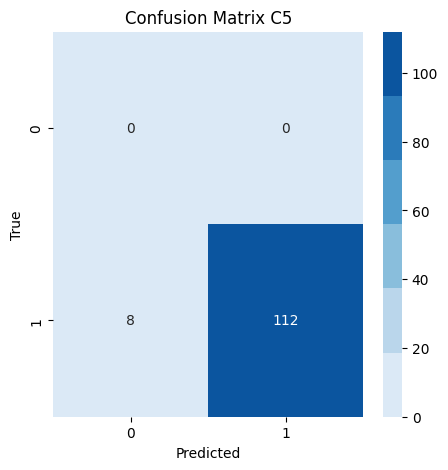

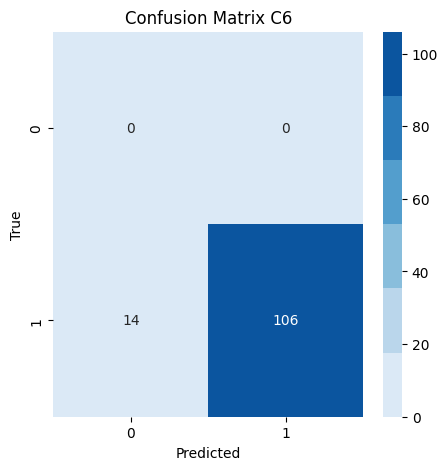

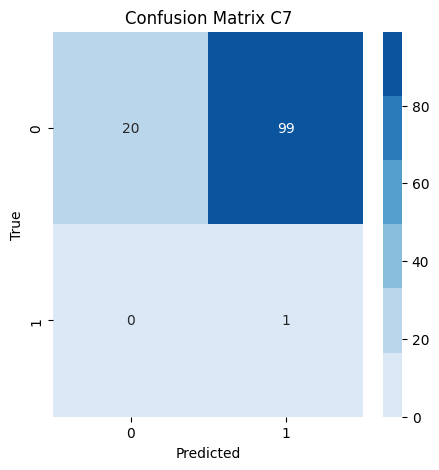

[[[  0   0]
  [ 11 109]]

 [[  0   0]
  [ 23  97]]

 [[  0   0]
  [  5 115]]

 [[  0   0]
  [  7 113]]

 [[  0   0]
  [  8 112]]

 [[  0   0]
  [ 14 106]]

 [[ 20  99]
  [  0   1]]]


In [53]:
# for i, confusion_matrix in enumerate(confusion_matrices):
#     print(f"Matriz de Confusión para Clase {i}:")
#     print(confusion_matrix)
for index,matriz in enumerate(accumulated_cm):
    accuracy, recall, f1 = get_metrics(matriz)
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("F1:", f1)
    plt.figure(figsize=(5,5))
    blue_palette = sns.color_palette("Blues")
    sns.heatmap(matriz,cmap=blue_palette, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix C{index+1}')
plt.show()
print(accumulated_cm)

In [16]:
print(accuracy_total)

76.91666666666667


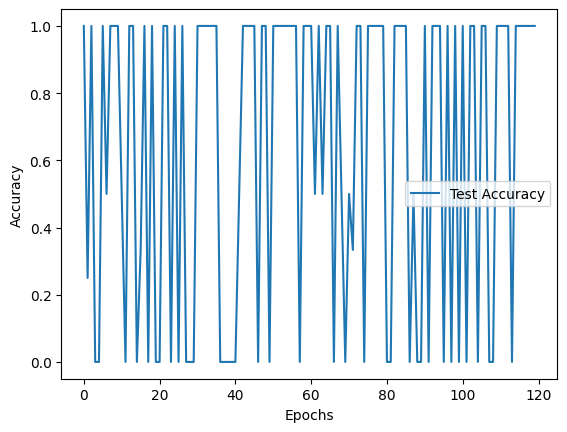

In [17]:
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## EfficientNet - GRU

In [6]:
# Define la función para preprocesar las imágenes para VGG16 y CombinedModel
def preprocess_image_for_combined_model(image):
    # Transformaciones para preprocesar las imágenes para VGG16
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Cambiar el tamaño a 224x224 (tamaño de entrada de la VGG16)
        transforms.ToTensor(),  # Convertir a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización requerida por VGG16
    ])

    preprocessed_image = transform(image)  # Aplica las transformaciones
    return preprocessed_image

In [7]:
class ImageDataGenerator:
    def __init__(self, df, ct_folder, max_samples, cervical, vertebrae_info, batch_size=32):
        self.df = df
        self.ct_folder = ct_folder
        self.batch_size = batch_size
        self.num_samples = len(df)
        self.current_idx = 0
        self.cervical = cervical
        self.vertebrae_info = vertebrae_info
        self.max_samples = max_samples

    def __iter__(self):
        return self

    def __next__(self):
        # batch_images = []
        # batch_labels = []
        batch_images = torch.zeros((self.batch_size, self.max_samples, 3, 224, 224))
        batch_labels = torch.zeros((self.batch_size, 1)) 
        max_length = self.max_samples
        for i in range(self.batch_size):
            if self.current_idx >= self.num_samples:
                self.current_idx = 0
                raise StopIteration

            ct_name = self.df.iloc[self.current_idx]['StudyInstanceUID']
            labels = [float(self.df.iloc[self.current_idx]['C' + str(self.cervical)])]
            filas_seleccionadas = self.vertebrae_info.loc[(self.vertebrae_info['StudyInstanceUID'] == ct_name) & (self.vertebrae_info['C' + str(self.cervical)] == 1)]
            # labels = self.df.iloc[self.current_idx][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].tolist()
            if not filas_seleccionadas.empty:
                slice_numbers = filas_seleccionadas['Slice'].tolist()
                with ZipFile(os.path.join(self.ct_folder, ct_name + '.zip'), 'r') as zip_ref:
                    image_files = zip_ref.namelist()

                    # Read and process each image
                    ct_images = []
                    counter = 0
                    for image_file in image_files:
                        slice_number = int(image_file.split('.jpg')[0].split('/')[-1])
                        if slice_number in slice_numbers:
                            with zip_ref.open(image_file) as img_file:
                                image = Image.open(img_file)  # Load the image
                                image = preprocess_image_for_combined_model(image)
                                # ct_images.append(image)
                                batch_images[i, counter] = image
                            counter += 1
                            if counter == max_length:
                                break
                    # ct_images = apply_PCA(torch.stack(ct_images))
                    # print(ct_images.shape)
                    while counter < max_length:
                        # ct_images.append(torch.zeros(3, 224, 224))
                        batch_images[i, counter] = torch.zeros(3, 224, 224)
                        counter += 1
                    # Append images and labels to the batch=
                    # batch_images.append(ct_images)
                    
                    # batch_labels.append(labels)
            batch_labels[i] = torch.tensor(labels)
            self.current_idx += 1
        # for el in batch_images:
        #     for el2 in el:
        #         print(type(el2))
        # batch_images = np.array(batch_images)
        # batch_labels = np.array(batch_labels)
        return batch_images, batch_labels
    
    def __len__(self):
        # Devuelve la longitud total del generador
        return self.num_samples

In [8]:
import torch.nn.functional as F

class CombinedModel(nn.Module):
    def __init__(self, efficientnet_output_size, gru_hidden_size, gru_num_layers, num_classes):
        super(CombinedModel, self).__init__()
        
        # Cargar EfficientNet preentrenado
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        # Eliminar la capa Fully Connected
        self.features = nn.Sequential(*list(self.efficientnet.children())[:-1])
        
        # Pooling Global Promedio
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # GRU Layer
        self.gru = nn.GRU(input_size=efficientnet_output_size, hidden_size=gru_hidden_size, batch_first=True)
        
        # Fully Connected Layer
        self.fc = nn.Linear(gru_hidden_size, 1)
        self.dropout = nn.Dropout(0.5)
        
        # Softmax
        # self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        x = x.view(batch_size * timesteps, C, H, W)
        
        # Pasar imágenes por EfficientNet
        x = self.features(x)
        
        # Pooling Global Promedio
        x = self.global_avg_pool(x).squeeze(-1).squeeze(-1)
        
        x = x.view(batch_size, timesteps, -1)
        # print(x.shape)
        # Pasar la secuencia de feature maps por la GRU
        out, _ = self.gru(x)
        # Usar solo la última salida de la secuencia
        out = out[:, -1, :]
        # Pasar por la capa Fully Connected
        out = self.dropout(self.fc(out))
        # Softmax
        out = self.sigmoid(out)
        
        return out

In [9]:
sample = 600

In [10]:
data_VGG = pd.read_csv('train_filtrado_images.csv')
data_VGG = data_VGG.sample(n=sample, random_state=42)

In [11]:
# Parámetros del modelo
vgg_output_size = 1280  # Tamaño de la salida de la VGG16
gru_hidden_size = 128  # Tamaño del estado oculto de la GRU
gru_num_layers = 2  # Número de capas en la GRU
num_classes = 7  # Reemplaza con el número de clases en tu problema

In [12]:
data_vertebrae = pd.read_csv('meta_train_with_vertebrae.csv')

In [13]:
train_data, test_data = train_test_split(data_VGG, test_size=0.2, random_state=42)

In [14]:
batch_size = 1

In [15]:
def get_matrix(vertebrae):
    # Cargar el modelo entrenado
    combined_model = CombinedModel(vgg_output_size, gru_hidden_size, gru_num_layers, num_classes)
    combined_model.load_state_dict(torch.load(f'modelo_entrenadoC{vertebrae}.pth'))
    combined_model.to('cuda')

    data_generator = ImageDataGenerator(train_data, 'imagenes_train', 75, vertebrae, data_vertebrae, batch_size=batch_size)
    data_generator_test = ImageDataGenerator(test_data, 'imagenes_train', 75, vertebrae, data_vertebrae, batch_size=batch_size)

    combined_model.eval()
    accuracy_iter = 0
    test_accuracy = []
    accuracy_total = 0
    confusion_matrices = []
    confusion_total = np.zeros((2, 2))
    with torch.no_grad():
        for i, (images_tensor, labels_tensor) in tqdm(enumerate(data_generator_test), total=len(data_generator_test)):
            image_tensor = images_tensor.to('cuda')
            label_tensor = labels_tensor.to('cuda')

            predictions = combined_model(image_tensor)

            threshold = 0.5
            predicted_labels = (predictions > threshold).float()  # 1 si es mayor al umbral, 0 de lo contrario
            predicted_labels_np = predicted_labels.cpu().numpy()

            true_labels = label_tensor.cpu().numpy()
            confusion_batch = confusion_matrix(true_labels, predicted_labels_np)

            # Acumula la matriz de confusión en la matriz total
            confusion_total += confusion_batch
    
    accuracy, recall, f1 = get_metrics(confusion_total.copy())
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("F1:", f1)

    plt.figure(figsize=(5,5))
    blue_palette = sns.color_palette("Blues")
    sns.heatmap(confusion_total,cmap=blue_palette, annot=True, fmt=".0f")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix C{vertebrae}')
    plt.show()

c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 120/120 [00:29<00:00,  4.05it/s]


Accuracy: 0.4946236559139785
Recall: 0.48936170212765956
F1: 0.4946236559139785


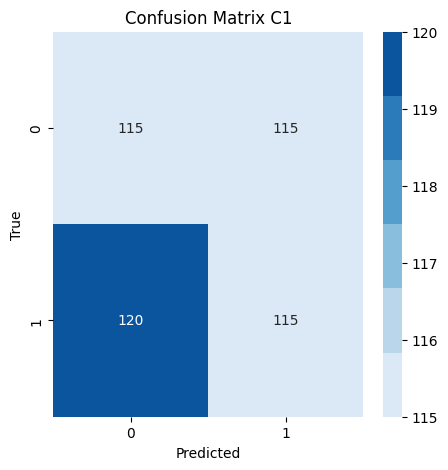

c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 120/120 [00:37<00:00,  3.20it/s]

Accuracy: 0.4888888888888889
Recall: 0.4782608695652174
F1: 0.4888888888888889


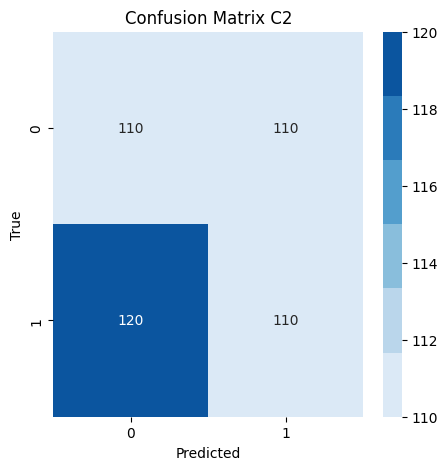

c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 120/120 [00:29<00:00,  4.04it/s]

Accuracy: 0.4968152866242038
Recall: 0.4936708860759494
F1: 0.4968152866242039


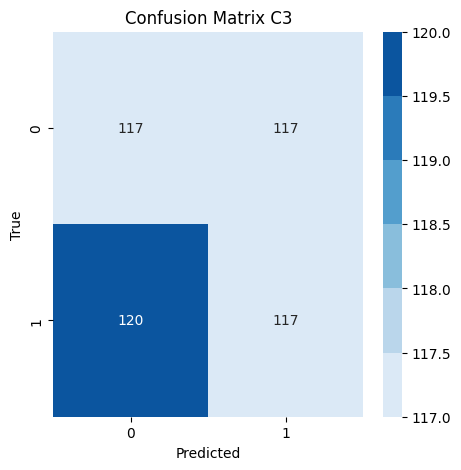

c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 120/120 [00:29<00:00,  4.01it/s]

Accuracy: 0.4900662251655629
Recall: 0.4826086956521739
F1: 0.49006622516556286


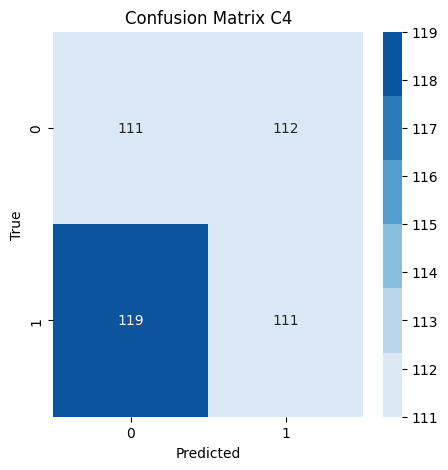

c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 120/120 [00:30<00:00,  3.93it/s]

Accuracy: 0.4935064935064935
Recall: 0.48717948717948717
F1: 0.49350649350649345


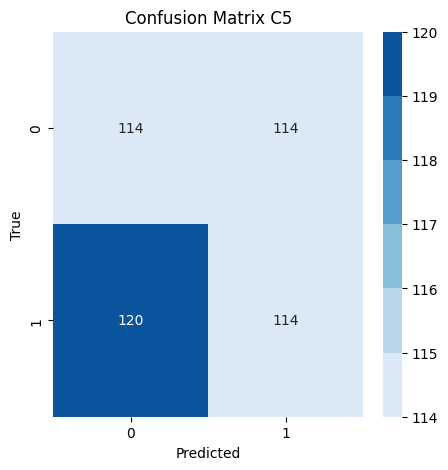

c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 120/120 [00:29<00:00,  4.05it/s]

Accuracy: 0.47754137115839246
Recall: 0.45701357466063347
F1: 0.47754137115839246


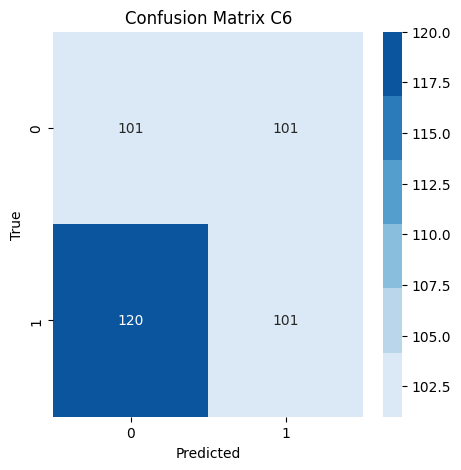

c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 120/120 [00:31<00:00,  3.87it/s]

Accuracy: 0.46464646464646464
Recall: 0.4339622641509434
F1: 0.46464646464646464


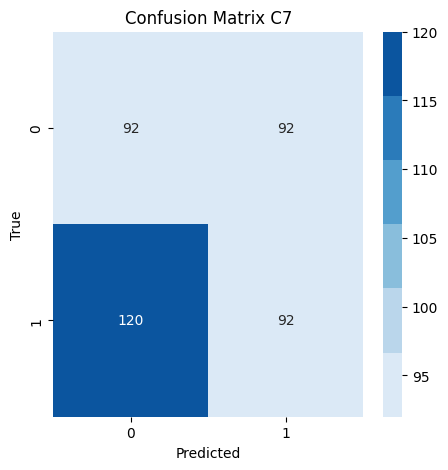

In [16]:
vertebrae = [1, 2, 3, 4, 5, 6, 7]

for vert in vertebrae:
    get_matrix(vert)